### PARAMETERS & CONSTANTS

```
IMG_WIDTH = 0 ##???? -> model.in
IMG_HEIGHT = 0 ##???? -> model.in
CAM_SIZE_X = 0 ##???? -> model.in
CAM_SIZE_Y = 0 ##???? -> model.in
cutoff_inner = 0. ##???? - WHAT VALUE? -> utilities.c

INCLINATION = 0. ##???? - WHAT VALUE? -> Inclination, i, in Degrees -> From paper.

##????stopx values -> Seems to be used in RadTrans -> IGNORED FOR NOW 

## icur, x, y, p, t, Xcam, Ucam -> WHAT VALUES ARE PASSED? SEE BELOW!
## icur, Xcam, Ucam are related to RadTrans, not RT
## p is for monolithic data storage, it seems
## t is useless for RT, as stationary spacetime
## x, y -> Current pixel location
## IGNORING icur, Xcam, Ucam, p, t
```

### Original Geodesic ODE:
$${\frac  {d^{2}x^{a}}{ds^{2}}}+\Gamma _{{bc}}^{{a}}{\frac  {dx^{b}}{ds}}{\frac  {dx^{c}}{ds}}=0$$
$$\Gamma _{{bc}}^{a}={\frac  {1}{2}}g^{{ad}}\left(g_{{cd,b}}+g_{{bd,c}}-g_{{bc,d}}\right)$$
### RK4:
$$\frac{\mathrm{d}X^\alpha}{\mathrm{d}\lambda} = U^\alpha$$
$$\frac{\mathrm{d}U^\alpha}{\mathrm{d}\lambda} = -\Gamma^\alpha_{\mu\nu}U^\mu U^\nu = A^\alpha$$
Changing $x$ to $X$ (4-Position); $U$ and $A$ are 4-velocity and 4-accelaration, respectively.
#### Coefficients:
* For $X^\alpha$:
$$C_{1,X^\alpha} = \Delta\lambda U^\alpha$$
$$C_{2,X^\alpha} = \Delta\lambda \left(U^\alpha + \frac{1}{2}C_{1,X^\alpha}\right)$$
$$C_{3,X^\alpha} = \Delta\lambda \left(U^\alpha + \frac{1}{2}C_{2,X^\alpha}\right)$$
$$C_{4,X^\alpha} = \Delta\lambda \left(U^\alpha + C_{3,X^\alpha}\right)$$
* For $U^\alpha$:
$$C_{1,U^\alpha} = \Delta\lambda f^\alpha\left(X^i, U^i\right)$$
$$C_{2,U^\alpha} = \Delta\lambda f^\alpha\left(X^i + \frac{1}{2}C_{1,U^i}, U^i + \frac{1}{2}C_{1,U^i}\right)$$
$$C_{3,U^\alpha} = \Delta\lambda f^\alpha\left(X^i + \frac{1}{2}C_{2,U^i}, U^i + \frac{1}{2}C_{2,U^i}\right)$$
$$C_{4,U^\alpha} = \Delta\lambda f^\alpha\left(X^i + C_{3,U^i}, U^i + C_{3,U^i}\right)$$
<br>
$f^\alpha(X^i, U^i) = f(X^1, X^2, X^3, X^4, U^1, U^2, U^3, U^4) = -\Gamma^\alpha_{\mu\nu}U^\mu U^\nu = -\Gamma^\alpha_{\mu\nu}\frac{\mathrm{d}X^\mu}{\mathrm{d}\lambda}\frac{\mathrm{d}X^\nu}{\mathrm{d}\lambda}$

#### Update at each step, $\Delta\lambda$:
$$X^\alpha_{new} = X^\alpha + \frac{1}{6}\left(C_{1, X^\alpha} + 2C_{2, X^\alpha} + 2C_{3, X^\alpha} + C_{4, X^\alpha}\right) + \mathcal{O}(\Delta\lambda^5)$$
$$U^\alpha_{new} = U^\alpha + \frac{1}{6}\left(C_{1, U^\alpha} + 2C_{2, U^\alpha} + 2C_{3, U^\alpha} + C_{4, U^\alpha}\right) + \mathcal{O}(\Delta\lambda^5)$$
<br>

#### For initial photon wave vector, $k^\alpha_0$:
$$L = -\alpha E\sqrt{1 - \cos^2 i}$$
$$Q = E^2\left[\beta^2 + \cos^2 i (\alpha^2 - 1)\right]$$
$$k_t = -E$$
$$k_\phi = L$$
$$k_\theta = sgn(\beta)\sqrt{|Q - L^2\cot^2\theta + E^2\cos^2\theta |}$$

### STRATEGY:
* Convert all to SI, maybe -> NO:TOO LARGE OR SMALL NUMBERS IN CALC -> STICK WITH GEOM UNITS.

1. Provide $x^\alpha_0$ and $k^\alpha_0$ in BL Coordinates -> Use values from Bronzwaer et al -> Convert to Cartesian for $x^\alpha_0$.
2. Provide $E$, $L$, $Q$ to define $k^\alpha_0$ -> Use values from Bronzwaer et al.
3. Calculate the coefficients, $C$ (TOTAL 8*4 = 32 IN NUMBER, per STEP)
4. Need a Christoffel Symbols calculator -> Use the `lambdified tensor`

#### PHOTON WAVE VECTOR (`photon_u` in code):
`photon_u` is a len 8 array, having initial 4-pos and 4-vel of the photon, at a particular pixel in the image.
* For $k^\alpha_0 == U^\alpha_0$:
    * $E$ -> BASE PARAM -> 1 in Bronzwaer's code
    * $L$ -> Depends on $E$, $\alpha$, $i$ -> Calculated
    * $Q$ -> Depends on $E$, $\alpha$, $\beta$, $i$ -> Calculated
* For $X^\alpha_0$:
    * $\alpha$ -> BASE PARAM -> Calculated
    * $\beta$ -> BASE PARAM -> Calculated
    * $i$ -> BASE PARAM -> 90Deg and 60Deg to be tested, as in Bronzwaer's Paper/Code
        * Initially, simpler inclinations should be tested.
    * $a$ -> BASE PARAM -> 0.998, from Bronzwaer's Paper/Code

#### INPUTS TO `integrate_geodesic`:
* `x` -> X-pos in image
* `y` -> Y-pos in image

#### NOTES:
* Spacetime -> Kerr
* Coordinates -> Boyer-Lindquist
* $G = c = 1$ (Geometrized Units)
* $r_s = 2$ (For RayTracing only)
* $M = 1$ (For RayTracing only)

### LIST OF FUNCTIONS AND THEIR USE (In RayTracing)
* 5/6 functions, in total:
    * `integrate_geodesic`
        * Takes `x` and `y` (initial photon pos in the image) -> Calculates `alpha` and `beta`, using them.
        * Calls:
            * `initialize_photon` : to initialize `photon_u`, the initial photon wave vector
            * `stepsize` : to obtain optimal stepsize, for the next integration step
            * `rk4_step` : to move integration by 1 step
    * `initialize_photon`
        * Prepares initial photon wave vector, at a particular `alpha`, `beta` or `x`, `y` in the image.
    * `stepsize`
        * Returns optimal integration step size.
    * `rk4_step`
        * RK4 Integrator for each step, based on the scheme above.
        * Calls:
            * `f_geodesic` : to obtain the RHS values, in above coupled ODES.
    * `f_geodesic`
        * Calls:
            * `cs_lambda` : Lambda Function, to calculate the Christoffel Symbols Matrix, at each step<br>
            ( ⬆ **THIS TAKES THE MOST AMOUNT OF TIME** ⬆ )

## Current Results:
1. Integrator works.
2. It's very slow, averaging ~5 minutes, per step, for the same initial conditions, as Bronzwaer's paper. For context, it will takes tens of hours to finish calculations, at this rate.
3. It takes an egregiously high amount of RAM. ![test](RAM USAGE.png)
4. `cs_lambda` calculations take too long.
5. 

## TODO:
* Implementation:
    * Understand RAPTOR's code and implement RayTracing (RT) : ✅
    * Find out the unit system in use and which one's more suitable : ✅ (Geom & Geom)
    * What Parametets & Constants are needed : ✅

* Optimization
    * Make `cs_lambda` a function, with pre-calculated values, like Bronzwaer have done. Although, not expecting speed improvements here.
    * Look into Verlet Implementation
    * JIT stuff
    
* Future Work:
    * Radiative Transfer
    * Still more optimization

# TESTING GROUND BELOW. CHECK `INTEGRATOR.ipynb` FOR ACTUAL CODE.

In [1]:
from einsteinpy.symbolic import ChristoffelSymbols, MetricTensor, Tensor
from einsteinpy.symbolic.predefined import Kerr
from sympy import symbols
import numpy as np
from einsteinpy.constant import c as sol

In [2]:
chris_sym = ChristoffelSymbols.from_metric(metric=Kerr()) # In BL Coordinates
chris_arr = chris_sym.simplify() # Simplified NDimArray

In [3]:
chris_arr

[[[0, r_s*(a**2 + r**2)*(-a**2*cos(theta)**2 + r**2)/(2*(a**2*cos(theta)**2 + r**2)**2*(a**2 + r**2 - r*r_s)), -2*a**2*r*r_s*sin(2*theta)/(a**2*cos(2*theta) + a**2 + 2*r**2)**2, 0], [r_s*(a**2 + r**2)*(-a**2*cos(theta)**2 + r**2)/(2*(a**2*cos(theta)**2 + r**2)**2*(a**2 + r**2 - r*r_s)), 0, 0, -a*r_s*(-a**4*cos(theta)**2 + a**2*r**2*cos(theta)**2 + a**2*r**2 + 3*r**4)*sin(theta)**2/(2*c*(a**2*cos(theta)**2 + r**2)**2*(a**2 + r**2 - r*r_s))], [-2*a**2*r*r_s*sin(2*theta)/(a**2*cos(2*theta) + a**2 + 2*r**2)**2, 0, 0, a**3*r*r_s*sin(theta)**3*cos(theta)/(c*(a**2*cos(theta)**2 + r**2)**2)], [0, -a*r_s*(-a**4*cos(theta)**2 + a**2*r**2*cos(theta)**2 + a**2*r**2 + 3*r**4)*sin(theta)**2/(2*c*(a**2*cos(theta)**2 + r**2)**2*(a**2 + r**2 - r*r_s)), a**3*r*r_s*sin(theta)**3*cos(theta)/(c*(a**2*cos(theta)**2 + r**2)**2), 0]], [[r_s*c**2*(-a**2*cos(theta)**2 + r**2)*(a**2 + r**2 - r*r_s)/(2*(a**2*cos(theta)**2 + r**2)**3), 0, 0, a*r_s*c*(a**2*cos(theta)**2 - r**2)*(a**2 + r**2 - r*r_s)*sin(theta)**2/(

In [4]:
from sympy import cos
r, a, theta, sigma, delta = symbols('r a theta sigma delta')

sigma   = r * r + a * a * cos(theta) * cos(theta)
delta   = r * r + a * a - 2. * r
sigma3 = sigma * sigma * sigma

gam_100 = delta / sigma3 * (2. * r * r - sigma)
gam_100.simplify()
# COMPARE WITH chris_arr[1, 0, 0] => SHOWS THAT M = 1 => r_s == 2.

(a**2*cos(theta)**2 - 1.0*r**2)*(-a**2 - r**2 + 2.0*r)/(a**2*cos(theta)**2 + r**2)**3

In [5]:
cs_lambda = chris_sym.tensor_lambdify()[1]

np.allclose(cs_lambda(t=0, r=0, theta=0, phi=0, a=1, c=1, r_s=2), cs_lambda(t=1000, r=0, theta=0, phi=0, a=1, c=1, r_s=2))
# 't' is useless, of course. This is a stationary metric.
# Beware of False Negatives, because of 'inf' in the arrays, due to chosen initial conditions.

e:\coding\winpython\wpy64-3740\python-3.7.4.amd64\lib\site-packages\numpy\__init__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  NumPy
e:\coding\winpython\wpy64-3740\python-3.7.4.amd64\lib\site-packages\numpy\__init__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  NumPy


False

In [6]:
type(np.array(cs_lambda(t=0, r=1, theta=1, phi=1, a=1, c=1, r_s=2)))

numpy.ndarray

In [7]:
np.array?

In [8]:
np.pi

3.141592653589793

In [9]:
l = False
r = 100
rc = 2000
mu0 = 0.2
arra = [10, np.log(r) if l else rc, np.arccos(mu0), 90./180. * np.pi]
arra

[10, 2000, 1.369438406004566, 1.5707963267948966]

In [10]:
np.sign(-2)

-1

In [11]:
import numpy as np
ax = np.arange(8)
axt = np.zeros(4)
axt[:] = ax[4:]
axt

array([4., 5., 6., 7.])

In [12]:
axtq = np.ones(4)
axtq

array([1., 1., 1., 1.])

In [13]:
ax[:]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [14]:
ax[:4] = axtq[:]
ax

array([1, 1, 1, 1, 4, 5, 6, 7])

In [15]:
np.abs(-20)

20

In [16]:
DIM = 2
g = np.ones((4,4,4), dtype=float)
u = np.ones(4, dtype=float)
au = np.zeros(4, dtype=float)

In [17]:
print('i', 'j', 'k', 'au', sep='\t\t')
print('--\t\t--\t\t--\t\t--')
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            au[i] -= g[i, j, k] * u[j] * u[k]
            print(i, j, k, au, sep='\t\t')

i		j		k		au
--		--		--		--
0		0		0		[-1.  0.  0.  0.]
0		0		1		[-2.  0.  0.  0.]
0		1		0		[-3.  0.  0.  0.]
0		1		1		[-4.  0.  0.  0.]
1		0		0		[-4. -1.  0.  0.]
1		0		1		[-4. -2.  0.  0.]
1		1		0		[-4. -3.  0.  0.]
1		1		1		[-4. -4.  0.  0.]


In [18]:
au[0] - g[0,0,0]*u[0]*u[0] - g[0,0,1]*u[0]*u[1] - g[0,1,0]*u[1]*u[0] - g[0,1,1]*u[1]*u[1]

-8.0

In [19]:
arra = np.random.rand(30).reshape((10,3))
arra

array([[0.51058625, 0.86055054, 0.98567648],
       [0.18085177, 0.50271058, 0.15778365],
       [0.77382761, 0.37291036, 0.18684177],
       [0.84769702, 0.00650707, 0.20256297],
       [0.76832964, 0.133751  , 0.39283366],
       [0.52581794, 0.43242643, 0.82121197],
       [0.33248898, 0.69981349, 0.71328133],
       [0.72116436, 0.44801304, 0.57220389],
       [0.6860434 , 0.14245101, 0.33897326],
       [0.95394705, 0.77425345, 0.35173137]])

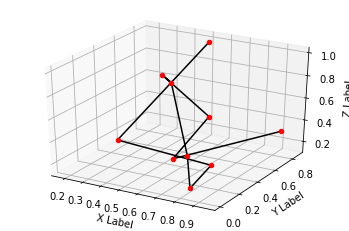

In [20]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for xs, ys, zs in arra:
    ax.scatter(xs, ys, zs, color='red')

ax.plot(arra[:,0], arra[:,1], arra[:,2], 'black')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [21]:
arra = np.zeros((10,3))

for i, j, k in list(arra):
    print(i, j, k)

0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0


In [22]:
arral =[[1,2,3], [4,5,6]]

In [23]:
for i, j, k in arral:
    print(i, j, k)
    
plt.plot(arral[:][0], arral[:][1], arral[:][2])

1 2 3
4 5 6


IndexError: list index out of range

In [ ]:
arral

In [ ]:
for i in range(1):
    print(i)

In [ ]:
##FROM core.c
# int lmax = (int)((real)IMG_HEIGHT*IMG_WIDTH/(real)maxsize + 0.5);
# if(lmax==0)
#         lmax=1.;

# int l1,l2;
# for(int l=0; l<lmax; l++) {
#     l1 =(int)l*maxsize;
#     l2 =(int)(l+1)*maxsize;


# l1 =(int)l*maxsize;
# l2 =(int)(l+1)*maxsize;

# if(l2 >(IMG_WIDTH)*(IMG_HEIGHT))
#         l2 =(IMG_WIDTH)*(IMG_HEIGHT);


# for(int i=l1; i < l2; i++) { // For all pixel rows (distributed over threads)...
#     int y=(int)(i/IMG_WIDTH);
#     int x=(int)(i%IMG_WIDTH);

#     // INTEGRATE THIS PIXEL'S GEODESIC AND PERFORM RADIATIVE TRANSFER AT DESIRED FREQUENCIES, STORE RESULTS
#     int icur=(int)(i-l1);
#     integrate_geodesic(icur,x,y,intensityfield2,frequencies,p,TIME_INIT,Xcam,Ucam);
# }